# Basic Regression with PyTorch in High Energy Physics
---

## Preamble

This is a basic tutorial to get you going with using PyTorch for regression tasks in High Energy Physics.
It is not meant to demonstrate the most optimal application by any means, but rather to provide an `walk-through` style guide.

There is an additional notebook which will walk-through a more powerful method.

The basic example here will operate on `ready-made` high-level features in a multivariate manor. Hence, our input feature vector will be `flat`. In the other notebook, we use a more complex method that instead operates on particle objects, e.g. jets, leptons, etc., with each object described by a vector of features. This will be referenced as a `particle set`.

Furthermore, with regards to `MLOps`, there are many features we will not be adding to this example, such as `hyperparameter tuning`, `model selection`, `cross-validation`, `early stopping`, `logging`, `monitoring`, `checkpoints`, serialisation to `ONNX` and ntuple injection etc.

One final note, we do not consider any `MC` weights in this example.

We assume you have the correct enviroment setup to run this notebook, following the instructions in the README.md file.

Okay, let's get started!

---

## The Task
---

In [ ]:
# = = = = = = = = = = = = = = = = = = = = = = = =
#                  SETUP BLOCK                  #
# = = = = = = = = = = = = = = = = = = = = = = = =

# All the libraries we will need for this tutorial :)
# See the README.md file for more information on how to install these libraries
# and get your environment setup if you haven't already!

# ================================================
# --> Data manipulation:
import pandas as pd
import numpy as np
import h5py

# --> PyTorch associated libraries:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --> Scikit-learn associated libraries:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# --> Plotting libraries:
import matplotlib.pyplot as plt
import seaborn as sns
# ================================================


# basic style for any plots
# ================================================
# --> some more options are: 
#       seaborn-darkgrid, grayscale
#       seaborn-dark, seaborn-whitegrid, 
#       seaborn-white, seaborn-ticks,
plt.style.use('ggplot')
sns.set_palette("husl") 
# ================================================

# Path to h5 file (stored in git LFS)
# ================================================
ttH_path = '/Users/levievans/Desktop/dataframe/ttH_fullSim_dev4vec_150k.h5'
# ================================================

# All global variables
# ================================================
PLOT_INPUTS = False                   # type: bool  
N_JETS = 7                            # type: int   
N_FEATURES = 5                        # type: int   
HIDDEN_DIM = 128                      # type: int   
REGRESSION_TARGET = 'truth_higgs_pt'  # type: str   
TEST_SIZE = 0.2                       # type: float 
BATCH_SIZE = 64                       # type: int   
NUM_EPOCHS = 30                       # type: int
DEBUG = False                         # type: bool  
LEARNING_RATE = 0.001                 # type: float 
MODEL_DIR = 'models'                  # type: str
MODEL_NAME = 'basic_model'            # type: str

# ================================================
# Extra truth-match information for Higgs b-jets
B_LEAD_HIGGS_VALUES = [1.0]           # type: list[float] # -> Leading b from Higgs
B_SUBLEAD_HIGGS_VALUES = [2.0]        # type: list[float] # -> Subleading b from Higgs
B_BOTH_HIGGS_VALUES = [3.0]           # type: list[float] # -> Both leading and subleading in same jet

print("\033[92m -- All global variables set and setup ran successfully! --\033[0m")

# References:
# -----------
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [ ]:
# = = = = = = = = = = = = = = = = = = = = = = = =
#            INITIALISING DATA BLOCK            #
# = = = = = = = = = = = = = = = = = = = = = = = =

# Now, we are going to load the dataframes and combine them
def load_data(file_path, process_name) -> pd.DataFrame:
    """
    Load the data from the h5 file and return a dataframe.
    
    Args:
        file_path (str): The path to the h5 file.
        process_name (str): The name of the process to load.
    
    Returns:
        pd.DataFrame: A dataframe containing the data.
    """
    with h5py.File(file_path, 'r') as f:
        dfs = []
        # the data is stored individually for each monte-carlo tag
        for version in ['mc16a', 'mc16d', 'mc16e']:
            group = f[f'IndividualFiles/combined_{process_name}_PP8_{version}_root']

            # we need to decode the bytes to strings for column names in the h5 file
            block0_columns = [name.decode('utf-8') for name in group['block0_items'][:]]
            block1_columns = [name.decode('utf-8') for name in group['block1_items'][:]]
            block2_columns = [name.decode('utf-8') for name in group['block2_items'][:]]

            # then we need to get the associated values for each block
            block0_values = group['block0_values'][:]
            block1_values = group['block1_values'][:]
            block2_values = group['block2_values'][:]

            # then we need to concatenate the values for each block
            # and create a dataframe for each version
            df_version = pd.concat([
                pd.DataFrame(block0_values, columns=block0_columns),
                pd.DataFrame(block1_values, columns=block1_columns),
                pd.DataFrame(block2_values, columns=block2_columns)
            ], axis=1)

            df_version['mc16_version'] = version
            dfs.append(df_version)

        df = pd.concat(dfs, axis=0, ignore_index=True) # we ignore the index to avoid duplicate indices!

        df['target'] = df[f'{REGRESSION_TARGET}'].astype(float)
        return df


# call the function to load the data and assign it to a the variable df
ttH_df = load_data(ttH_path, 'ttH')
df = ttH_df

print("\033[92m -- All data loaded successfully! --\033[0m")


## The Model definition
---

In [ ]:
# = = = = = = = = = = = = = = = = = = = = = = = =
#             MODEL DEFINITION BLOCK            #
# = = = = = = = = = = = = = = = = = = = = = = = =

# A very basic neural network with 3 layers
class MyBasicModel(nn.Module):
    """
    A basic neural network with 3 layers, inherited from the `nn.Module` class.
    ----
    See https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
    
    This is a basic neural network with 3 layers. 
    It is used to demonstrate the basic concepts of a neural network in PyTorch.
    
    In the init method, we define the actual layers of our network. For this, we use the `nn.Linear` class. 
    This class creates a linear transformation of the input.
    
    For example, if we have an input of size `input_dim`, then the `nn.Linear` layer will create a matrix of size 
    `input_dim x hidden_dim`. The entries of this matrix are simply the `weights` of the linear transformation, 
    which are randomly initialised.
    
    We then apply a non-linearity to the output of the linear transformation using the `torch.relu` function in the
    `forward` method. The `relu` function is simply the `rectified linear unit` function, which is a very simple 
    non-linearity that returns the input if it is positive, and 0 otherwise.
    
    Args:
    ----
        input_dim: the dimension of the input
        hidden_dim: the dimension of the hidden layer
        output_dim: the dimension of the output
    
    Returns:
    ----
        x: the output of the model
    """
    def __init__(self, input_dim, hidden_dim, output_dim) -> None:
        super(MyBasicModel, self).__init__()
        #print(f"Input dim: {input_dim}, Hidden dim: {hidden_dim}, Output dim: {output_dim}")  # Debug print
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        #print(f"Input shape: {x.shape}")     # Debug print if needed
        
        # flatten the input
        x = x.reshape(x.size(0), -1)
        
        # print(f"After reshape: {x.shape}")  # Debug print if needed
        
        x = torch.relu(self.fc1(x))
       # print(f"After fc1: {x.shape}")       # Debug print if needed
       
        x = torch.relu(self.fc2(x))
        #print(f"After fc2: {x.shape}")       # Debug print if needed
        
        x = self.fc3(x)
        #print(f"After fc3: {x.shape}")       # Debug print if needed
        
        return x
    
    @property
    def count_parameters(self) -> int:
        """
        Count the number of trainable parameters in the model.
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


print("\033[92m -- Model defined successfully! --\033[0m")


## Data Preparation
---

In [ ]:
# = = = = = = = = = = = = = = = = = = = = = = = =
#             PREPARATION BLOCK                 #
# = = = = = = = = = = = = = = = = = = = = = = = =

class EventDataset(Dataset):
    def __init__(self, df , jets_cols, target_column) -> None:
        """
        Custom training dataset class
        ----
        This class is used to create a custom training dataset for the model
        from a pandas dataframe. It inherits from the `torch.utils.data.Dataset` 
        class.
        
        Args:
            df (DataFrame): The dataset.
            jets_cols (list of str): Column names for jet features.
            target_column (str): Column name for the target label.
            regression_target (bool): Whether this is a regression task.
        """
        self.jets = df[jets_cols].values
        self.targets = df[target_column].values
        self.n_jets = N_JETS
        self.n_features = N_FEATURES

    def __len__(self) -> int:
        """Returns the length of the dataset.
        """
        return len(self.targets)

    def __getitem__(self, idx: int) -> dict:
        """Returns the item at index idx, i.e. the jet features and target.
        """
        # Reshape the jet features to [n_jets, n_features]
        jets_sample = torch.FloatTensor(self.jets[idx]).reshape(self.n_jets, self.n_features)
        
        # Convert target to tensor
        target = torch.tensor(float(self.targets[idx]), dtype=torch.float32)
        
        return {
                'jets': jets_sample,
                'target': target
            }


def has_both_higgs_bjets(event_row) -> bool:
    """
    Check if an event has both leading and subleading b-jets from Higgs.
    
    Args:
        event_row (pd.Series): A row from the dataframe.
        
    Returns:
        bool: True if the event has both leading and subleading b-jets from Higgs, False otherwise.
    """
    # Check all jet columns for the event
    has_leading = False
    has_subleading = False
    
    for i in range(1, N_JETS + 1):  
        truthmatch_col = f'jet_truthmatch_{i}'
        if truthmatch_col not in event_row:
            continue
            
        value = event_row[truthmatch_col]
        
        # check to see if the jet has both b-quarks from the Higgs decay
        if value in B_BOTH_HIGGS_VALUES:
            return True
            
        # check to see if the jet has the leading b-quark from the Higgs decay
        if value in B_LEAD_HIGGS_VALUES:
            has_leading = True
            
        # check to see if the jet has the subleading b-quark from the Higgs decay
        if value in B_SUBLEAD_HIGGS_VALUES:
            has_subleading = True
            
    # Return True if both types are found
    return has_leading and has_subleading


# NOTE: using the truth information is "cheating", but we do it here to demonstrate the method and
# get some level of decent performance. In reality, we would not have this information when 
# running inference on data.

# define the columns for the jet features we want to use in the model training
jets_cols = [
    'jet_pt_1', 'jet_eta_1', 'jet_phi_1', 'jet_e_1', 'jet_truthmatch_1',
    'jet_pt_2', 'jet_eta_2', 'jet_phi_2', 'jet_e_2', 'jet_truthmatch_2',
    'jet_pt_3', 'jet_eta_3', 'jet_phi_3', 'jet_e_3', 'jet_truthmatch_3',
    'jet_pt_4', 'jet_eta_4', 'jet_phi_4', 'jet_e_4', 'jet_truthmatch_4',
    'jet_pt_5', 'jet_eta_5', 'jet_phi_5', 'jet_e_5', 'jet_truthmatch_5',
    'jet_pt_6', 'jet_eta_6', 'jet_phi_6', 'jet_e_6', 'jet_truthmatch_6',
    'jet_pt_7', 'jet_eta_7', 'jet_phi_7', 'jet_e_7', 'jet_truthmatch_7',
]

# get the events that have both leading and subleading b-quarks from the Higgs decay
# some events will have only one b-quark from the Higgs decay, and so we will not use these events
# for the training of the model.
# Benefits: 
# - We are only training on events that have both b-quarks from the Higgs decay
# - This should give us a more accurate model as we are not mixing events with different Higgs decay topologies
#    and events where we 'lose' one of the b-quarks.
complete_higgs_events = df[df.apply(has_both_higgs_bjets, axis=1)]

# Prepare the data for each object group, taking only events that pass the `has_both_higgs_bjets` selection.
X = complete_higgs_events[jets_cols].values

# Next, we want to split and scale the data

# split the data into training and test sets
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=42, shuffle=True)

# scale the data using the `MinMaxScaler` scaler
scaler_vars = MinMaxScaler()

# fit the scaler to the training data
df_train[jets_cols] = scaler_vars.fit_transform(df_train[jets_cols])

# transform the test data using the fitted scaler
# we want to apply the same scaler to the test data as we did to the training data
# if we did not do this, the test data would be on a different scale to the training data
# and this would bias the model
df_test[jets_cols] = scaler_vars.transform(df_test[jets_cols])

# Clean the data and target variable 
# (NOTE: data cleaning is very good practise, and this is just a simple, rough and ready, example
# where we only remove events with a target value < 0!)
df_train = df_train[df_train['target'] > 0]
df_test = df_test[df_test['target'] > 0]

# We should also scale the target variable as well...
target_scaler = MinMaxScaler()
df_train['target'] = target_scaler.fit_transform(df_train[['target']]).flatten()
df_test['target'] = target_scaler.transform(df_test[['target']]).flatten()

print("\033[92m--- Data Prepared and Scaled Successfully! ---\033[0m")


## Data Loading
---

In [ ]:
# = = = = = = = = = = = = = = = = = = = = = = = =
#             LOADING DATA BLOCK                #
# = = = = = = = = = = = = = = = = = = = = = = = =

# Create datasets for regression using our custom EventDataset class
train_dataset_reg = EventDataset(df_train, jets_cols, target_column='target')
test_dataset_reg = EventDataset(df_test, jets_cols, target_column='target')

# Create data loaders using PyTorchs native DataLoader class
train_loader_reg = DataLoader(train_dataset_reg, batch_size=BATCH_SIZE, shuffle=True)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=BATCH_SIZE)

print("\033[92m--- Event Data Loaded Successfully! ---\033[0m")


## Training the Model
---

In [ ]:
# = = = = = = = = = = = = = = = = = = = = = = = =
#               REGRESSION BLOCK                #
# = = = = = = = = = = = = = = = = = = = = = = = =

# Now let's try regression
print("\033[92m--- Regression Task ---\033[0m")


# Define the regression model by instantiating the MyBasicModel class
regression_model = MyBasicModel(input_dim=N_FEATURES * N_JETS, hidden_dim=HIDDEN_DIM, output_dim=1)
trainable_parameters = regression_model.count_parameters

print(f"INFO: Number of trainable parameters: {trainable_parameters}")

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimiser (AdamW is a good default choice!)
optimiser = torch.optim.AdamW(regression_model.parameters(), lr=LEARNING_RATE)

# Define the device to train on (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device (this is really only needed if you are using a GPU)
regression_model.to(device)

# Create lists to store the trainig and test losses
train_losses_reg = []
test_losses_reg = []

# Now can start training the model!
print(f"INFO: Training regression model on {device}")

for epoch in range(NUM_EPOCHS):
    regression_model.train()
    train_loss = 0
    for batch in train_loader_reg:
        batch_X, batch_target = batch['jets'].to(device), batch['target'].to(device) # Again, only need to do this if using a GPU

        # zero the gradients 
        # this is done to avoid accumulating gradients from previous batches, so for each batch we need to `zero the gradients`
        optimiser.zero_grad()

        # forward pass
        outputs = regression_model(batch_X)
        
        # squeeze the output to get a 1D tensor to match the loss computation
        outputs = outputs.squeeze()
        batch_target = batch_target.view(-1)

        # compute the loss
        loss = loss_fn(outputs, batch_target)

        # backpropagate the loss
        loss.backward()

        # update the weights
        optimiser.step()

        # add the loss to the total loss
        train_loss += loss.item()
    
    # Validation
    # we do a similar process to the training loop, but we do not update the weights here
    # we only want to evaluate the model on the test set
    # .eval() is used to set the model to evaluation mode, this is because some layers, such as dropout if we were using it, behave differently in training and evaluation mode.
    regression_model.eval()
    test_loss = 0
    
    # store the predictions and actual values for evaluation
    predictions = []
    actuals = []

    # we do not need to track the gradients for the test set, so we use `torch.no_grad()`
    with torch.no_grad():
        # iterate over the test set
        for batch in test_loader_reg:
            batch_X, batch_target = batch['jets'].to(device), batch['target'].to(device)

            # forward pass
            outputs = regression_model(batch_X)
            outputs = outputs.squeeze()
            batch_target = batch_target.view(-1) 

            # compute the loss
            test_loss += loss_fn(outputs, batch_target).item()
            
            # Store predictions and actual values for evaluation
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_target.cpu().numpy())

    # compute the average loss for the epoch
    train_losses_reg.append(train_loss / len(train_loader_reg))
    test_losses_reg.append(test_loss / len(test_loader_reg))

    # compute the R-squared score
    from sklearn.metrics import r2_score
    r2 = r2_score(actuals, predictions)

    print(f'INFO: Epoch [{epoch+1}/{NUM_EPOCHS}], '
          f'Train Loss: {train_losses_reg[-1]:.4f}, '
          f'Test Loss: {test_losses_reg[-1]:.4f}, '
          f'R-squared Score: {r2:.4f}')

print(" Trained for ", NUM_EPOCHS, " epochs")

# and we are done training and validating the model!
print("\033[92m--- Training Completed! ---\033[0m")

# we can save the model as a `.pth` file (this is a binary file that contains the model's state_dict)
# alternatively, we can save the model as a `.pt` file (this is a text file that contains the model's state_dict)
# or as a `.pkl` file (this is a pickle file that contains the model's state_dict)
# or even as a .npz file (this is a numpy file that contains the model's state_dict)
torch.save(regression_model.state_dict(), f'{MODEL_DIR}/{MODEL_NAME}_regression_model.pth')

# we can convert the model to ONNX format (not covered in this tutorial)
# this is useful for deployment and for using the model in other frameworks
# we can convert the model to ONNX format using the `torch.onnx.export` function
# we can then load the model from the ONNX file using the `torch.onnx.load` function


# also useful, we can load the model from the `.pth` file, and then use it to make predictions
# or continue training the model if desired
# regression_model = MyBasicModel(input_dim=N_FEATURES * N_JETS, hidden_dim=HIDDEN_DIM, output_dim=1)
# regression_model.load_state_dict(torch.load('regression_model.pth'))


### Validating the training

In [ ]:
# = = = = = = = = = = = = = = = = = = = = = = = =
#              TRAINING CURVE PLOT              #
# = = = = = = = = = = = = = = = = = = = = = = = =

# we can plot the training and validation losses to spot overfitting or underfitting

plt.figure(figsize=(10, 5))
plt.plot(train_losses_reg, label='Training Loss')
plt.plot(test_losses_reg, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

## Understanding model performance
---

In [ ]:
# = = = = = = = = = = = = = = = = = = = = = = = =
#             MIGRATION MATRIX PLOT             #
# = = = = = = = = = = = = = = = = = = = = = = = =

# we can create a migration matrix to see how the model performs for different Higgs pT bins
# this is a good way to understand the model's performance and to see if there are any biases in the model.

# convert predicted and actual target values to GeV
# we need to first inverse transform the target values to the original scale, and then divide by 1000 to convert to GeV
actuals_gev = target_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten() / 1000
predictions_gev = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten() / 1000

# Define the bins for Higgs pT (from STXS-based binning)
bins = [0, 60, 120, 200, 300, 450, np.inf]
bin_labels = ['[0,60)', '[60,120)', '[120,200)', '[200,300)', '[300,450)', '[450,inf)']

# Assign each value to a bin
actuals_binned = np.digitize(actuals_gev, bins) - 1
predictions_binned = np.digitize(predictions_gev, bins) - 1

# Create the migration matrix
migration_matrix = confusion_matrix(actuals_binned, predictions_binned, 
                                   labels=range(len(bin_labels)), normalize='true', )

# Flip the matrix vertically to have 0-60 at the bottom
migration_matrix = np.flipud(migration_matrix)
flipped_bin_labels = bin_labels.copy()
flipped_bin_labels.reverse()

# Plot the migration matrix
plt.figure(figsize=(10, 8))
cmap = sns.color_palette("Blues", as_cmap=True)
ax = sns.heatmap(migration_matrix, 
                annot=True,                      # --> Show values in cells
                fmt='.2f',                       # --> Format to 2 decimal places
                cmap=cmap,                       # --> Use our custom colormap
                xticklabels=bin_labels,          # --> X-axis labels
                yticklabels=flipped_bin_labels,  # --> Y-axis labels (flipped)
                vmin=0, vmax=1,                  # --> Fix color scale from 0 to 1
                annot_kws={"size": 12,           # --> Larger annotation text
                           "weight": "bold"},    # --> Bold annotation text
                linewidths=0.5,                  # --> Add thin lines between cells
                linecolor='white',               # --> White lines between cells
                cbar_kws={"shrink": 0.8,         # --> Smaller colorbar
                          "label": "Fraction of Events"})  # Colorbar label

plt.xlabel('Predicted Higgs pT (GeV)', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('True Higgs pT (GeV)', fontsize=14, fontweight='bold', labelpad=15)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('black')
plt.tight_layout()
plt.show()

# Print some statistics about the binning
for i, label in enumerate(bin_labels):
    true_count = np.sum(actuals_binned == i)
    pred_count = np.sum(predictions_binned == i)
    print(f"Bin {label} GeV: {true_count} true events, {pred_count} predicted events")

### Comparing the prediction to the truth values

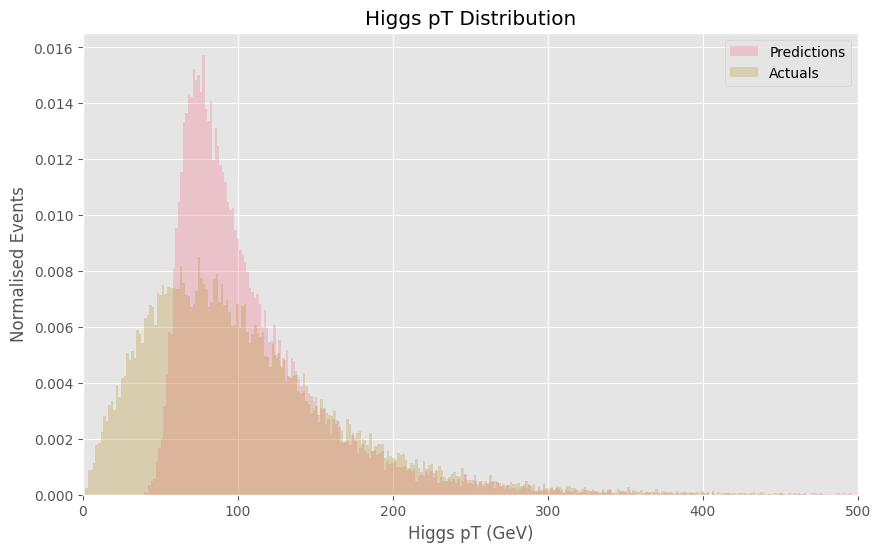

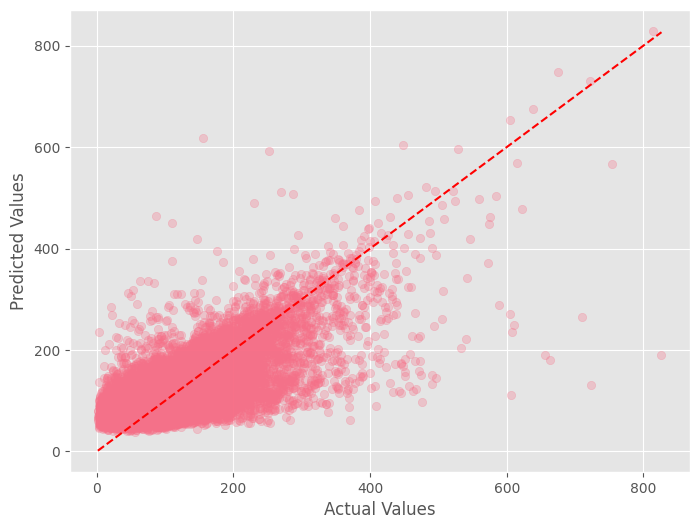

In [79]:
# Higgs pT distribution comparison
plt.figure(figsize=(10, 6))
plt.hist(predictions_gev, bins=500, alpha=0.3, density=True)
plt.hist(actuals_gev, bins=500, alpha=0.3, density=True)
plt.xlabel('Higgs pT (GeV)')
plt.xlim(0, 500)
plt.ylabel('Normalised Events')
plt.title('Higgs pT Distribution')
plt.legend(['Predictions', 'Actuals'])
plt.show()

# Scatter plot of predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(actuals_gev, predictions_gev, alpha=0.3)
plt.plot([min(actuals_gev), max(actuals_gev)], [min(actuals_gev), max(actuals_gev)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### Residuals plot

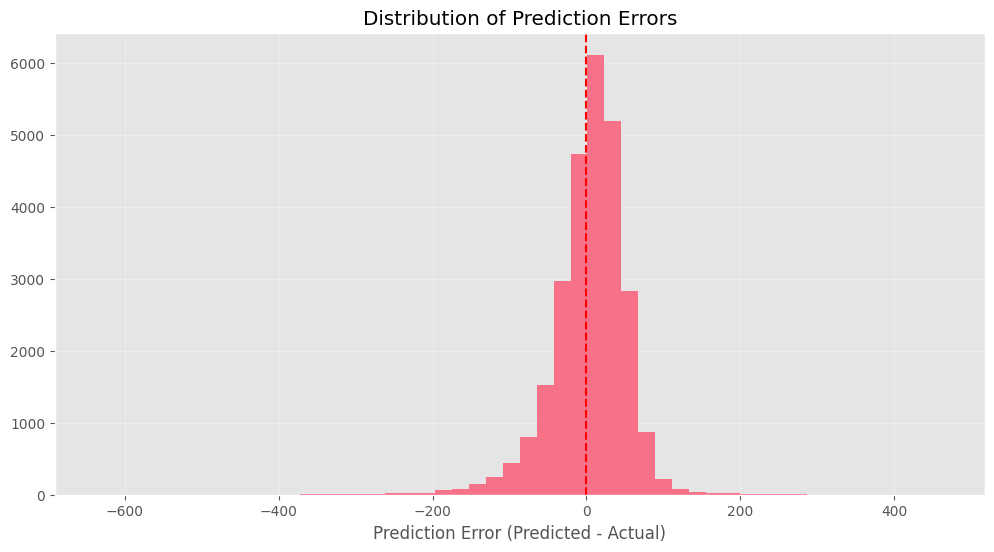

INFO: Regression target statistics (GeV): min=1.48, max=826.37, mean=105.51
INFO: Regression prediction statistics (GeV): min=39.12, max=829.30, mean=109.40


In [80]:
# Residuals plot
# this is a distribution of the prediction errors :--> (predicted - actual)
plt.figure(figsize=(12, 6))
residuals = np.array(predictions_gev) - np.array(actuals_gev)
plt.hist(residuals, bins=50)
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

print(f"INFO: Regression target statistics (GeV): min={actuals_gev.min():.2f}, max={actuals_gev.max():.2f}, mean={actuals_gev.mean():.2f}")
print(f"INFO: Regression prediction statistics (GeV): min={predictions_gev.min():.2f}, max={predictions_gev.max():.2f}, mean={predictions_gev.mean():.2f}")

### Statistics

In [81]:
# Calculate and print some statistics about the predictions
mean_error = np.mean(residuals)
mean_abs_error = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(np.square(residuals)))

print(f"INFO: Mean Error: {mean_error:.2f}")
print(f"INFO: Mean Absolute Error: {mean_abs_error:.2f}")
print(f"INFO: Root Mean Square Error: {rmse:.2f}")

INFO: Mean Error: 3.89
INFO: Mean Absolute Error: 35.42
INFO: Root Mean Square Error: 48.70


# The End!

---

---
## Some Extra fun if you want to try a different model...

You will want to call this model like this:  `SetTransformerModel(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, num_heads=2, num_layers=2)`.

Note that now we do not need to flatten the input, as we are using the `nn.TransformerEncoderLayer` class, which expects a 3D input of shape `[batch_size, n_jets, n_features]`!

In [ ]:
class SetTransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads=2, num_layers=2) -> None:
        super(SetTransformerModel, self).__init__()
        
        # need the input dimension to be compatible with number of attention heads
        self.embedding_dim = (input_dim // num_heads) * num_heads
        if self.embedding_dim != input_dim:
            # add a linear projection to make dimensions compatible
            self.input_projection = nn.Linear(input_dim, self.embedding_dim)
        else:
            # if the dimensions are already compatible, just use an identity projection
            self.input_projection = nn.Identity()
        
        # Multi-head self attention layers from the `nn.TransformerEncoderLayer` class
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=self.embedding_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                batch_first=True
            ) for _ in range(num_layers)
        ])
        
        # Global pooling and final prediction layers
        self.pooling = nn.Sequential(
            nn.Linear(self.embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        # x shape: [batch_size, n_jets, n_features]
        
        # Project input if necessary
        x = self.input_projection(x)
        
        # Apply self-attention layers
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Global pooling (mean across jets)
        x = torch.mean(x, dim=1)  # [batch_size, embedding_dim]
        
        # Final prediction
        x = self.pooling(x)  # [batch_size, 1]
        
        return x

## Appendix I - Information on the Dataset (h5)